In [88]:
import numpy as np
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, scale
from sklearn.cross_validation import train_test_split

import pandas as pd
from pickle import load, dump

from keras import metrics
import keras.backend as K
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.layers.merge import *
from keras.layers.convolutional import *
from keras.layers.embeddings import *
from keras.layers.wrappers import *
from keras.layers.normalization import *
from keras.layers.advanced_activations import *
from keras.models import *
from keras.callbacks import *
from keras.utils.vis_utils import *
from keras.utils import *

from IPython.display import SVG
import matplotlib.pyplot as plt
import itertools

In [89]:
def read_data(path):
    Xs, Ys = pd.read_pickle(path)
    

    Xtrain, Xvalid, Xtest = Xs[:,:5725], Xs[:,5725:5725*2], Xs[:,5725*2:]
    
    Ys = np.concatenate([to_categorical(Ys[rowid])[None,:,:] for rowid in range(len(Ys))])
    Ytrain, Yvalid, Ytest = Ys[:,:5725], Ys[:,5725:5725*2], Ys[:,5725*2:]

    return Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest

In [90]:
Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest = read_data("../data/input.pkl")
# Xtrain = np.concatenate([Xtrain, Xtest], axis=1)
# Ytrain = np.concatenate([Ytrain, Ytest], axis=1)

In [91]:
print(f"train, X size: {Xtrain.shape}, Y size: {Ytrain.shape}")
print(f"valid, X size: {Xvalid.shape}, Y size: {Yvalid.shape}")

train, X size: (28, 5725, 100, 5), Y size: (28, 5725, 2)
valid, X size: (28, 5725, 100, 5), Y size: (28, 5725, 2)


# Model definition

In [92]:
%%time 
# channel last
input_shape = (100, 5)
input = Input(shape=input_shape)

nn = Conv1D(50, 10, padding='same', activation="relu")(input)
nn = MaxPooling1D(5, strides=5, padding='same')(nn)
nn = Dropout(0.5)(nn)
nn = Flatten()(nn)
nn = Dense(625, activation="relu")(nn)
nn = Dense(125, activation="relu")(nn)
nn = Dense(2, activation="softmax")(nn)

clf = Model(inputs=input, outputs=nn)
clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

CPU times: user 208 ms, sys: 36 ms, total: 244 ms
Wall time: 301 ms


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 100, 5)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 100, 50)           2550      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 20, 50)            0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 625)               625625    
_________________________________________________________________
dense_30 (Dense)             (None, 125)               78250     
__________

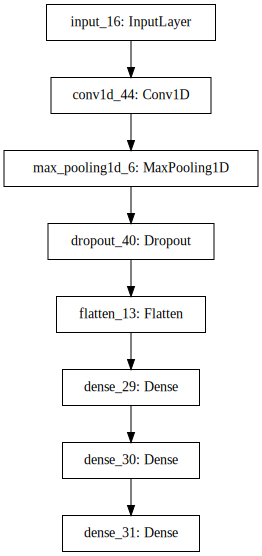

In [93]:
clf.summary()
SVG(model_to_dot(clf).create(prog='dot', format='svg'))

In [97]:
run_name = "deepchrome final 002"
tb = TensorBoard(log_dir=f"../log/{run_name}", batch_size=32, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f"../model/{run_name}.h5", verbose=1, save_best_only=True, monitor="val_acc")
stopper = EarlyStopping(monitor="val_acc", patience=3)

In [96]:
epigenome = 1
clf.fit(
    Xtrain[epigenome],
    Ytrain[epigenome],
    batch_size=4000,
    callbacks = [tb, checkpointer, stopper],
    epochs=1000,
    shuffle=True,
    validation_data=(Xvalid[epigenome], Yvalid[epigenome]),
    verbose=0)

Epoch 00000: val_acc improved from -inf to 0.64716, saving model to ../model/deepchrome final 001.h5
Epoch 00001: val_acc improved from 0.64716 to 0.77013, saving model to ../model/deepchrome final 001.h5
Epoch 00002: val_acc improved from 0.77013 to 0.77048, saving model to ../model/deepchrome final 001.h5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc improved from 0.77048 to 0.81520, saving model to ../model/deepchrome final 001.h5
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve


KeyboardInterrupt: 

In [109]:
print(classification_report(Ytest[epigenome][:,1], predY[:,1]> 0.5))

             precision    recall  f1-score   support

        0.0       0.82      0.77      0.79      4279
        1.0       0.77      0.82      0.80      4066

avg / total       0.80      0.79      0.79      8345



In [99]:
predY = clf.predict(Xtest[epigenome])
print(classification_report(Ytest[epigenome][:,1], predY[:,1]> 0.5))

ValueError: Mix type of y not allowed, got types {'unknown', 'continuous-multioutput'}